<center> Análise exploratória dos dados: Geração por usina em base horária </center>


Primeiro, faremos a importação das bibliotecas que serão utilizadas nessa análise exploratória:

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
from datetime import datetime
from IPython.display import display
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
from sklearn.metrics import mean_absolute_error as mae 

%matplotlib inline 

Carregamento dos dados de treino (Anos 2014 a 2018) em um só DataFrame:

In [10]:
arquivos = glob("C:/Users/ppgar/OneDrive/Documentos/Dados/Treino/*.csv")
treino = pd.DataFrame([])
for arquivo in arquivos:
    dados = pd.read_csv(arquivo, sep = ";")
    treino = pd.concat([treino, dados])
    print(arquivo, "carregado.")

C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2000.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2001.csv carregado.


C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2002.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2003.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2004.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2005.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2006.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2007.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2008.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2009.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2010.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2011.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2012.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Treino\GERACAO_USINA_2013.csv carregado.
C:/Users/ppgar/O

Podemos fazer uma visualização dos dados rápida dos dados do início e do final do DataFrame, para termos uma idéia de como ele é formado, além de obter estatísticas básicas acerca do valor de geração por hora:

In [11]:
display(treino.head())
display(treino.tail())
treino['val_geracao'].describe() #Calcula estatísticas básicas

,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao,id_ons
0,2000-01-01 00:00:00,N,NORTE,PA,PARA,TIPO I,HIDROELÉTRICA,Hidráulica,Tucuruí,UHE.PH.PA.002889-4.01,2422.5,NaN
1,2000-01-01 00:00:00,NE,NORDESTE,AL,ALAGOAS,TIPO I,HIDROELÉTRICA,Hidráulica,Xingó,UHE.PH.SE.027053-9.01,1995.6,NaN
2,2000-01-01 00:00:00,NE,NORDESTE,BA,BAHIA,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,Pequenas Centrais Hidroelétricas da Chesf,-,13.0,NaN
3,2000-01-01 00:00:00,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Apolônio Sales,UHE.PH.AL.001510-5.01,202.5,NaN
4,2000-01-01 00:00:00,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Paulo Afonso II,UHE.PH.BA.027048-2.01,269.8,NaN


,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao,id_ons
4288651,2018-12-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO III,TÉRMICA,Biomassa,Colorado,UTE.AI.SP.028094-1.01,21.000,NaN
4288652,2018-12-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO III,TÉRMICA,Biomassa,Guarani Cruz Alta,UTE.AI.SP.027796-7.01,13.000,NaN
4288653,2018-12-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,São Salvador,UHE.PH.TO.028567-6.01,119.600,NaN
4288654,2018-12-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,Lajeado,UHE.PH.TO.001304-8.01,476.403,NaN
4288655,2018-12-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,Peixe Angical,UHE.PH.TO.028353-3.01,301.851,NaN


count    4.533057e+07
mean     1.902831e+02
std      5.536470e+02
min      0.000000e+00
25%      0.000000e+00
50%      3.539300e+01
75%      1.305300e+02
max      7.979900e+03
Name: val_geracao, dtype: float64

Como iremos fazer uma análise sobre a série histórica dos subsistemas e do Brasil inteiro, e os dois métodos escolhidos se baseiam apenas nas datas, iremos utilizar apenas os valores da geração de energia agrupados por mês e subsistema, e suas respectivas datas. Assim, podemos excluir as colunas que não serão utilizadas na análise para poupar tempo e memória utilizada. Faremos também um tratamento de data e hora, para podermos agrupar a geração de energia por mês:

In [12]:

#-----------------------Tratamento de data e hora ----------------------_#
treino['din_instante'] = pd.to_datetime(treino['din_instante'])
treino['din_instante'] = treino['din_instante'].dt.strftime('%Y-%m')
#-----------------------Renomeanto a coluna 'din_instante' para 'data'------------------------#
treino = treino.rename(columns = {'din_instante': 'data'})

Quais são os subsistemas presentes nos dados?

In [13]:
display(pd.unique(treino['id_subsistema']))

array(['N', 'NE', 'S', 'SE'], dtype=object)

Agora, agruparemos os dados de treino pelo seu subsistema, para realizarmos uma análise da geração de energia ao longo do tempo, por subsistema:

In [14]:
#-------------------Separando por subsistema ---------------------#


norte = treino[treino['id_subsistema'] == "N"]
nordeste = treino[treino['id_subsistema'] == "NE"]
sul = treino[treino['id_subsistema'] == "S"]
sudeste = treino[treino['id_subsistema'] == "SE"]

In [15]:
#--------------------Agrupando por data --------------#
norte = norte.groupby('data').sum('val_geracao')
sul = sul.groupby('data').sum('val_geracao')
sudeste = sudeste.groupby('data').sum('val_geracao')
nordeste = nordeste.groupby('data').sum('val_geracao')
brasil = pd.DataFrame()
brasil['val_geracao'] = norte['val_geracao'] + sul['val_geracao'] + sudeste['val_geracao'] + nordeste['val_geracao']

Vamos desenhar o gráfico da geração da energia por data, para observamos como esses dados se distribuem pelo tempo:

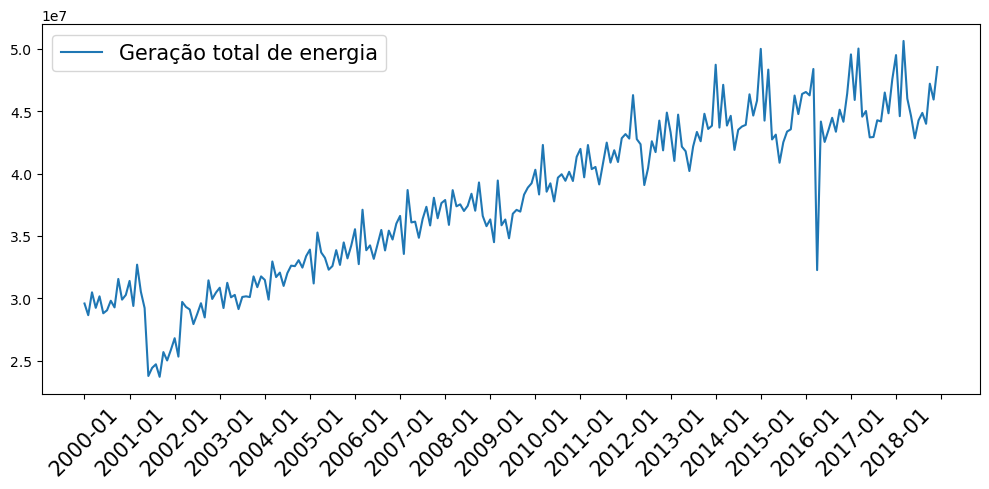

In [16]:
plt.figure(figsize = [10, 5])
plt.plot(brasil['val_geracao'], label = "Geração total de energia")
plt.legend(loc='upper left', prop={'size': 15})
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12))
plt.xticks(rotation = 45, fontsize = 15)
plt.tight_layout()


No gráfico acima, podemos observar uma queda abrupta na produção nos anos de 2000/2001. Essa queda foi muito noticiada na época, chamada de Apagão. Vemos também um aumento "ziguezagueado" na geração de energia ao longo dos anos. Vemos também algo "estranho" no início do ano de 2016, com uma queda muito acentuada.
Calcularemos a tendência dessa série histórica de cada subsistema, retirando o ruído:

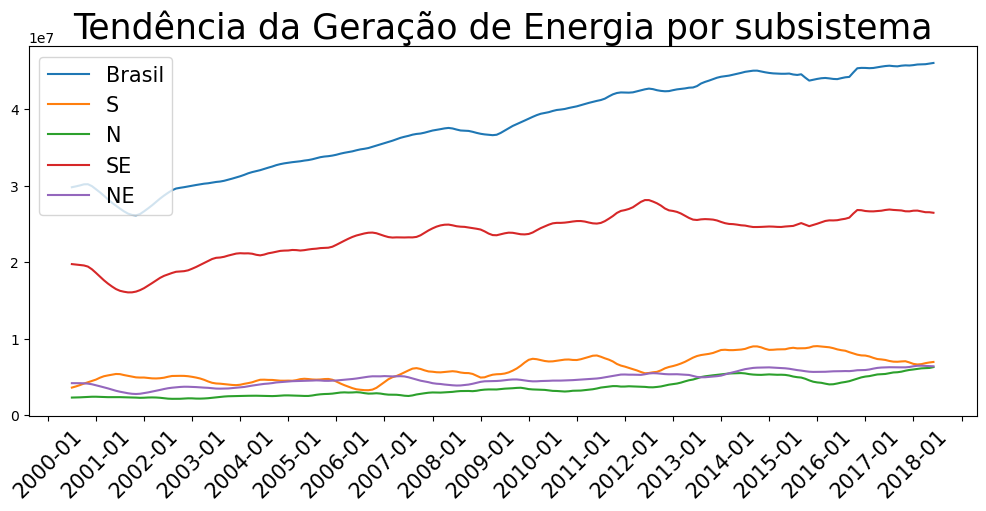

In [17]:
decompositionN = seasonal_decompose(norte, model='multiplicative', period=12)  # decomposição anual
decompositionNE = seasonal_decompose(nordeste, model='multiplicative', period=12)  # decomposição anual
decompositionSE = seasonal_decompose(sudeste, model='multiplicative', period=12)  # decomposição anual
decompositionS = seasonal_decompose(sul, model='multiplicative', period=12)  # decomposição anual
sazonalidadeBrasil = seasonal_decompose(brasil, model = 'multiplicative', period = 12)




#---------------------------Criação do gráfico das tendências ---------------------------#


plt.figure(figsize = [10, 5])
plt.plot(sazonalidadeBrasil.trend, label = "Brasil")
plt.plot(decompositionS.trend, label = "S")
plt.plot(decompositionN.trend, label = "N")
plt.plot(decompositionSE.trend, label = "SE")
plt.plot(decompositionNE.trend, label = "NE")

#-------------------------------Configurações do gráfico -------------------------------#
plt.legend(loc='upper left', prop={'size': 15})
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12))
plt.xticks(rotation = 45, fontsize = 15)
plt.tight_layout()

plt.title("Tendência da Geração de Energia por subsistema", fontsize = 25)
plt.show()


Podemos também verificar a sazonalidade dos nossos dados:

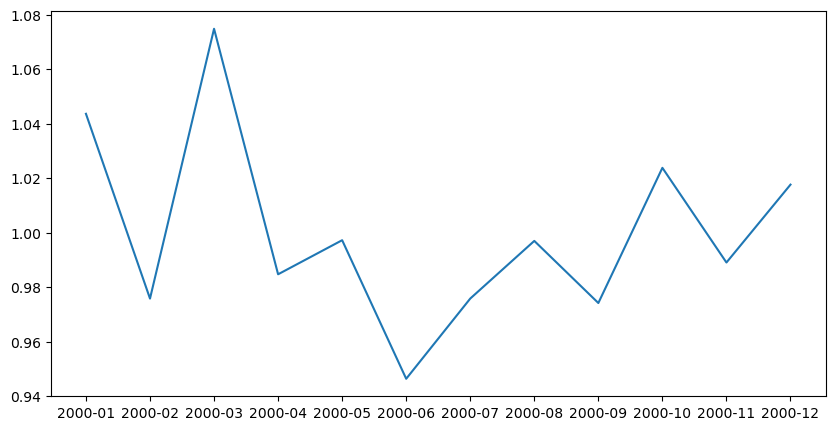

In [18]:
plt.figure(figsize = [10, 5])
plt.plot(sazonalidadeBrasil.seasonal.iloc[0:12])

Nesse gráfico, podemos ver certos comportamentos da geração de energia por mês do ano de 2000, por exemplo, como uma queda da geração em fevereiro e junho, e uma alta em março e outubro.

Carregando os dados de validação (Anos 2019 e 2020):

In [19]:
arquivos = glob("C:/Users/ppgar/OneDrive/Documentos/Dados/Validacao/*.csv")
validacao = pd.DataFrame([])
for arquivo in arquivos:
    dados = pd.read_csv(arquivo, sep = ";")
    print(arquivo, "carregado.")
    validacao = pd.concat([validacao, dados])

C:/Users/ppgar/OneDrive/Documentos/Dados/Validacao\GERACAO_USINA_2019.csv carregado.
C:/Users/ppgar/OneDrive/Documentos/Dados/Validacao\GERACAO_USINA_2020.csv carregado.


Tratamento de data e hora dos dados de validação, separando apenas ano e mês para serem utilizados:

In [20]:
validacao['din_instante'] = pd.to_datetime(validacao['din_instante'])
validacao['din_instante'] = validacao['din_instante'].dt.strftime('%Y-%m')
validacao = validacao.rename(columns = {'din_instante': 'data'})


Agrupamento dos dados de cada subsistema:

In [21]:
valid_n = validacao[validacao['id_subsistema'] == "N"]
valid_ne = validacao[validacao['id_subsistema'] == "NE"]
valid_s = validacao[validacao['id_subsistema'] == "S"]
valid_se = validacao[validacao['id_subsistema'] == "SE"]


In [22]:
valid_n = valid_n.groupby('data').sum('val_geracao')
valid_se = valid_se.groupby('data').sum('val_geracao')
valid_s = valid_s.groupby('data').sum('val_geracao')
valid_ne = valid_ne.groupby('data').sum('val_geracao')

valid_brasil = pd.DataFrame()
valid_brasil['val_geracao'] = valid_n['val_geracao'] + valid_se['val_geracao'] + valid_s['val_geracao'] + valid_ne['val_geracao']


Para esse problema, primeiramente utilizaremos um modelo especializado em trabalhar com séries temporais, o método ARIMA. Por se basear apenas nos dados históricos, podemos reduzir os dados apenas ao valor da geração e a data de tal valor. Assim, faremos estimativas de geração para os anos de 2019 e 2020 de cada subsistema individualmente, e também para todo o Brasil.

In [23]:
modelN = auto_arima(norte, seasonal=True, m=12)
modelS = auto_arima(sul, seasonal = True, m=12)
modelNE = auto_arima(nordeste, seasonal = True, m=12)
modelSE = auto_arima(sudeste, seasonal = True, m=12)
modelBrasil = auto_arima(brasil, seasonal=True, m=12)


forecastN = modelN.predict(n_periods=len(valid_n))
forecastN = pd.DataFrame(forecastN,index = valid_n.index,columns=['Prediction'])

forecastSE = modelSE.predict(n_periods=len(valid_s))
forecastSE = pd.DataFrame(forecastSE,index = valid_se.index,columns=['Prediction'])

forecastNE = modelNE.predict(n_periods=len(valid_ne))
forecastNE = pd.DataFrame(forecastNE,index = valid_ne.index,columns=['Prediction'])

forecastS = modelS.predict(n_periods=len(valid_s))
forecastS = pd.DataFrame(forecastS,index = valid_s.index,columns=['Prediction'])


forecastBrasil = modelBrasil.predict(n_periods=len(valid_brasil))
forecastBrasil = pd.DataFrame(forecastBrasil,index = valid_brasil.index,columns=['Prediction'])

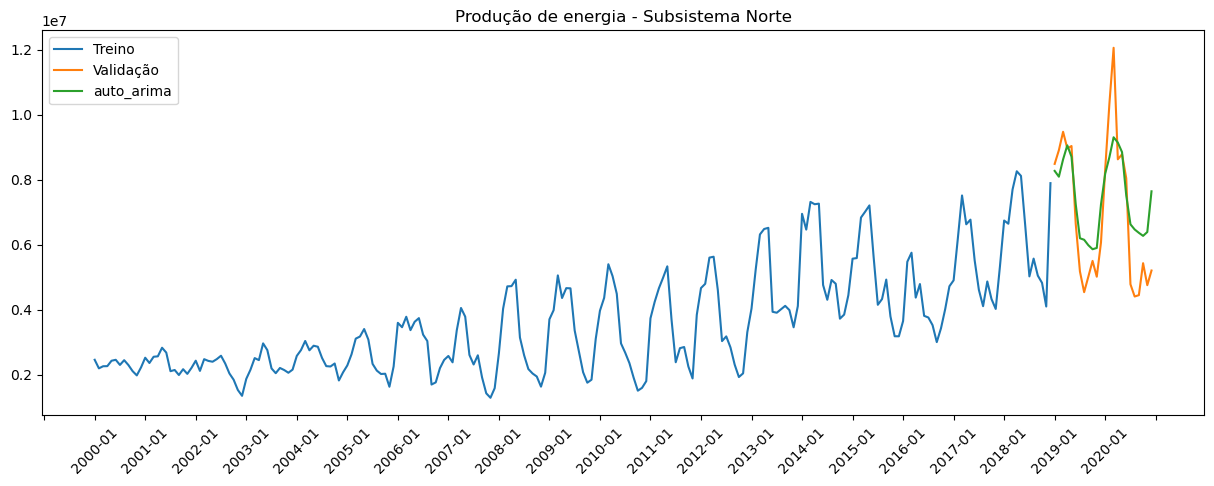

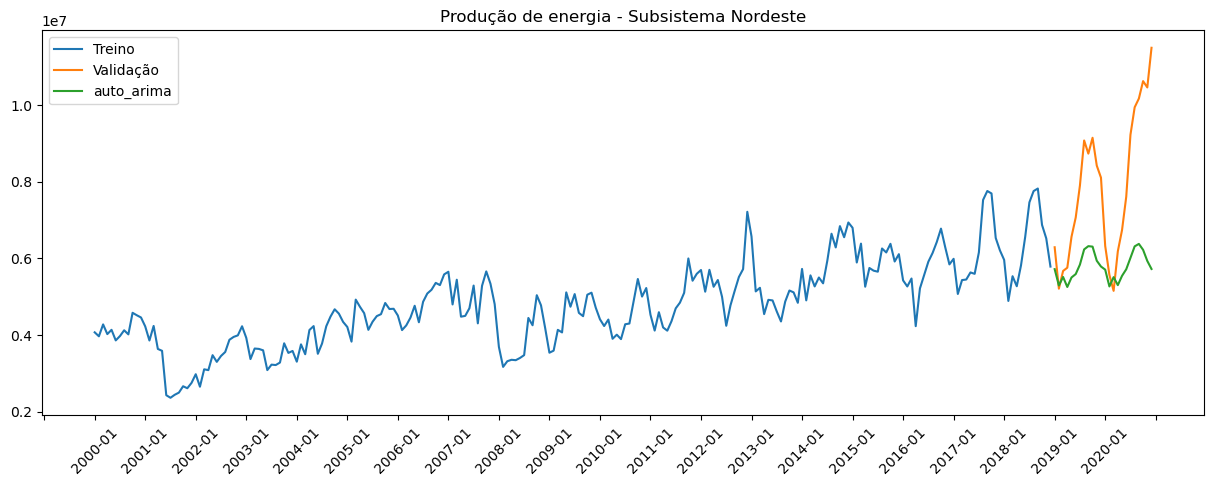

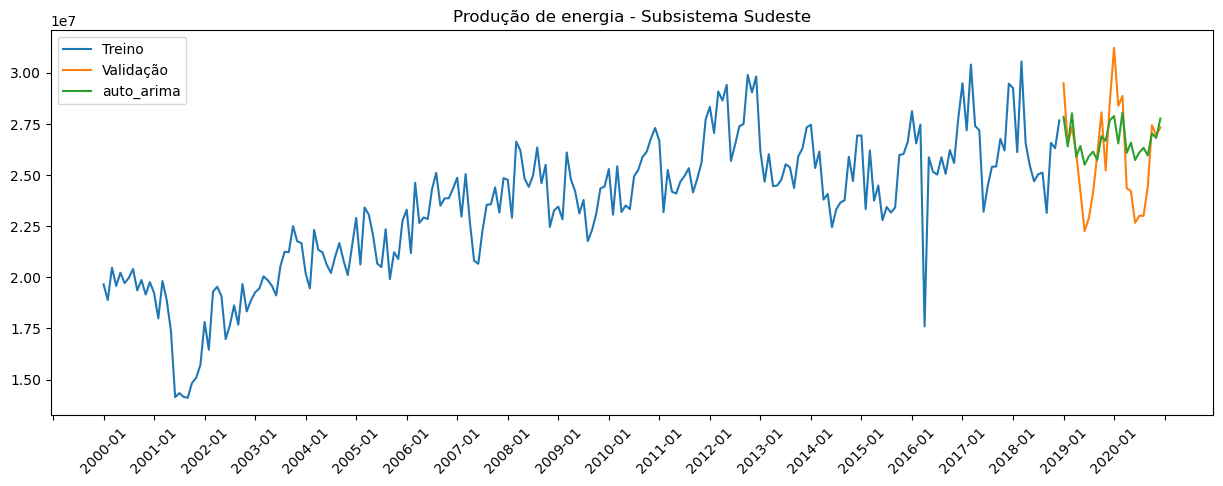

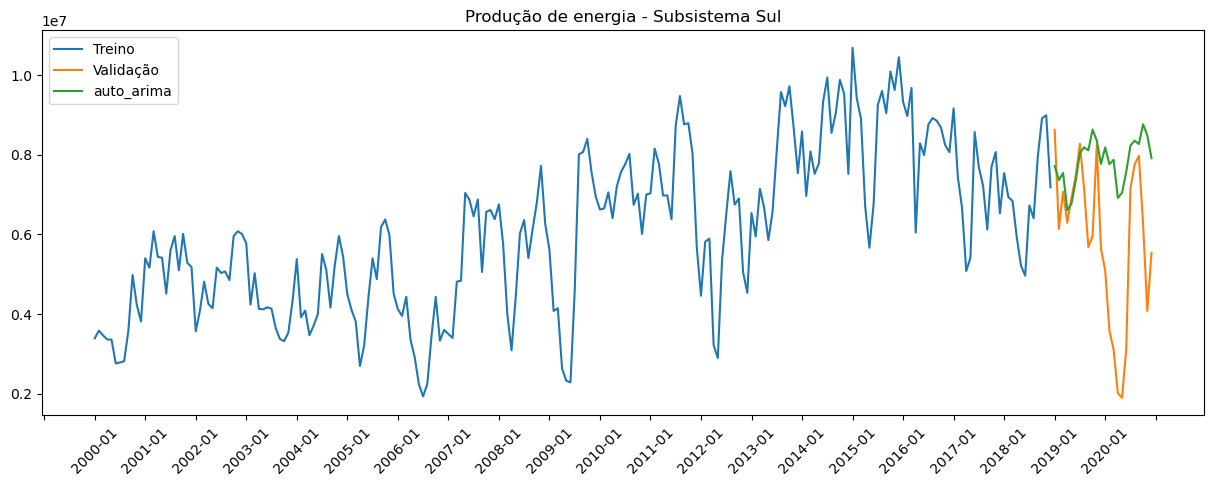

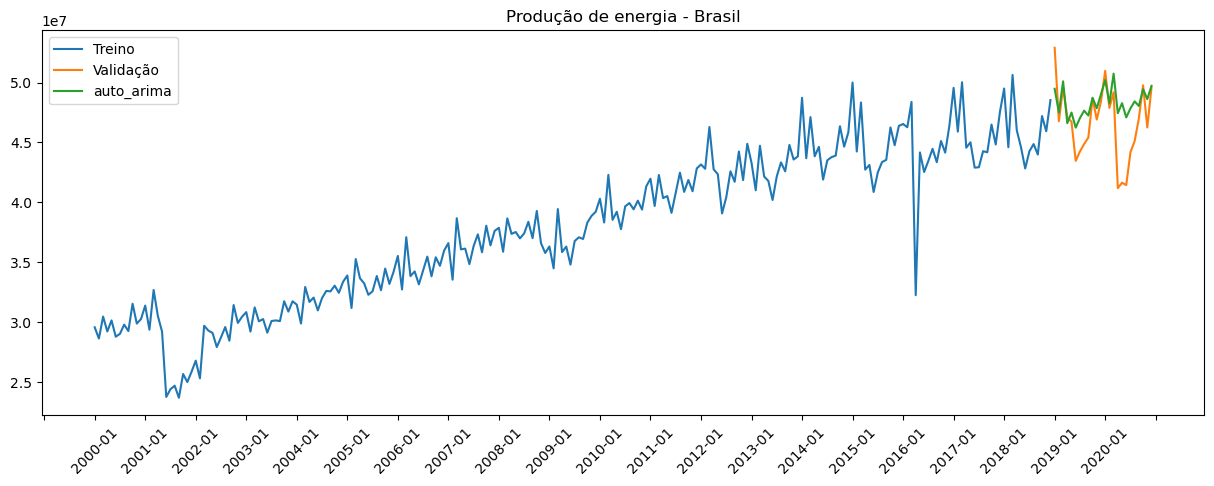

In [24]:
#--------Desenho dos gráficos da geração de todos subsistemas e Brasil. Histórico, validação e predição ---------#



plt.figure(figsize = (15,5))
plt.title('Produção de energia - Subsistema Norte')
plt.plot(norte, label='Treino')
plt.plot(valid_n, label='Validação')
plt.plot(forecastN, label='auto_arima')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12))
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (15,5))
plt.title('Produção de energia - Subsistema Nordeste')
plt.plot(nordeste, label='Treino')
plt.plot(valid_ne, label='Validação')
plt.plot(forecastNE, label='auto_arima')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12))
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (15,5))
plt.title('Produção de energia - Subsistema Sudeste')
plt.plot(sudeste, label='Treino')
plt.plot(valid_se, label='Validação')
plt.plot(forecastSE, label='auto_arima')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12))
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (15,5))
plt.title('Produção de energia - Subsistema Sul')
plt.plot(sul, label='Treino')
plt.plot(valid_s, label='Validação')
plt.plot(forecastS, label='auto_arima')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12))
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize = (15,5))
plt.title('Produção de energia - Brasil')
plt.plot(brasil, label='Treino')
plt.plot(valid_brasil, label='Validação')
plt.plot(forecastBrasil, label='auto_arima')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12))
plt.xticks(rotation = 45)
plt.show()

Compararemos agora o desempenho do método ARIMA com o XGBoost. Apesar de ser um método menos utilizado para séries temporais, artigos recentes apontam que esse método possui um ótimo desempenho (artigos citados no relatório). Para isso, traremos os dados da série temporal para um formato tabular, com "mês" e "ano" sendo colunas independentes:

In [25]:
brasil['data'] = pd.to_datetime(brasil.index)
brasil['mes'] = brasil['data'].dt.month
brasil['ano'] = brasil['data'].dt.year

valid_brasil['data'] = pd.to_datetime(valid_brasil.index)
valid_brasil['mes'] = valid_brasil['data'].dt.month
valid_brasil['ano'] = valid_brasil['data'].dt.year

Como usaremos agora as colunas "mes" e "ano" como variáveis de nosso problema, é prudente verificarmos sua correlação com "val_geracao", que é nossa incógnita.
Para isso, usaremos os coeficientes de correlação de Pearson:

In [26]:
brasil.corr()

,val_geracao,mes,ano
val_geracao,1.000000,5.445217e-03,9.408979e-01
mes,0.005445,1.000000e+00,5.951752e-15
ano,0.940898,5.951752e-15,1.000000e+00


Aqui, vemos uma correlação muito próxima a 1 da variável "ano" com "val_geracao", o que indica uma correlação muito forte. Já para "mês", vemos uma correlação linear muito fraca, próxima a 0.05. Podemos verificar essa correlação também de uma forma gráfica, desenhando o gráfico de total de geração por ano:

<AxesSubplot:xlabel='mes'>

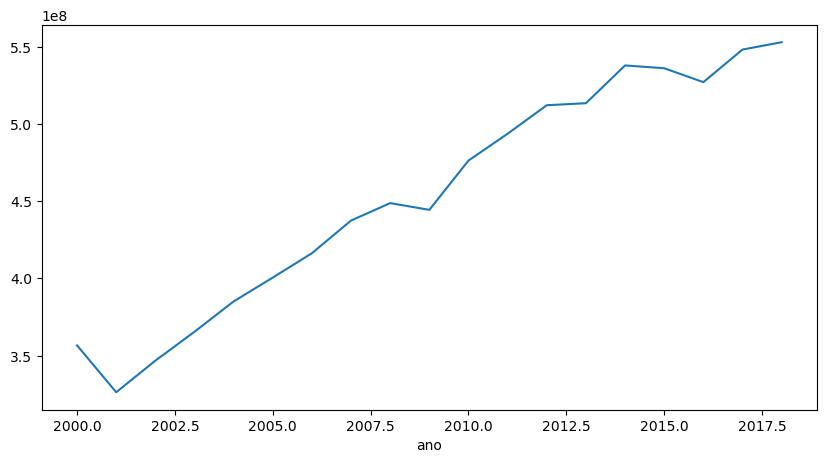

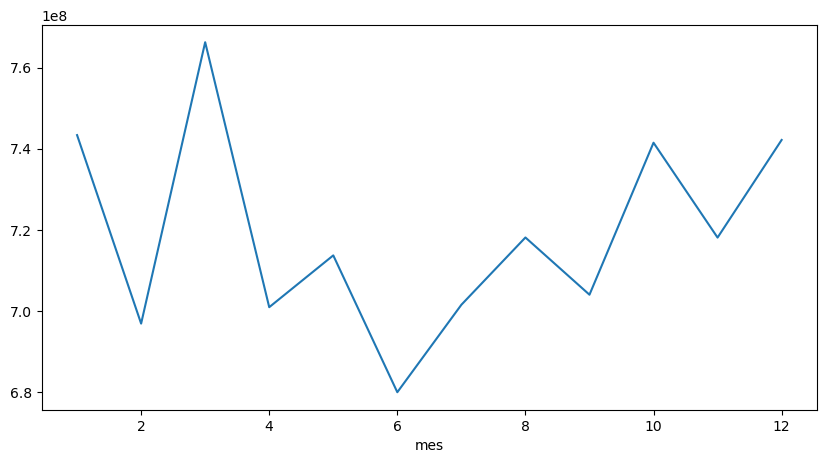

In [27]:
brasil_pano = brasil.groupby('ano').sum('val_geracao')
brasil_pmes = brasil.groupby('mes').sum('val_geracao')

plt.figure(figsize = (10,5))
brasil_pano['val_geracao'].plot()
plt.figure(figsize = (10,5))
brasil_pmes['val_geracao'].plot()

Apesar de ter uma correlação linear muito fraca, ainda podemos ver algumas tendências, como o mês de fevereiro e junho tendo uma produção baixa, em relação aos outros meses. Por estarmos utilizando um algoritmo trabalha tanto com linearidade quanto com não-linearidade, manteremos a coluna "mês", na buscar dessa "sazonalidade" que ocorre.

Aqui definiremos o modelo XGBoost, e faremos sua predição para nossos dados.

Text(0.5, 1.0, 'Série histórica e comparação de métodos')

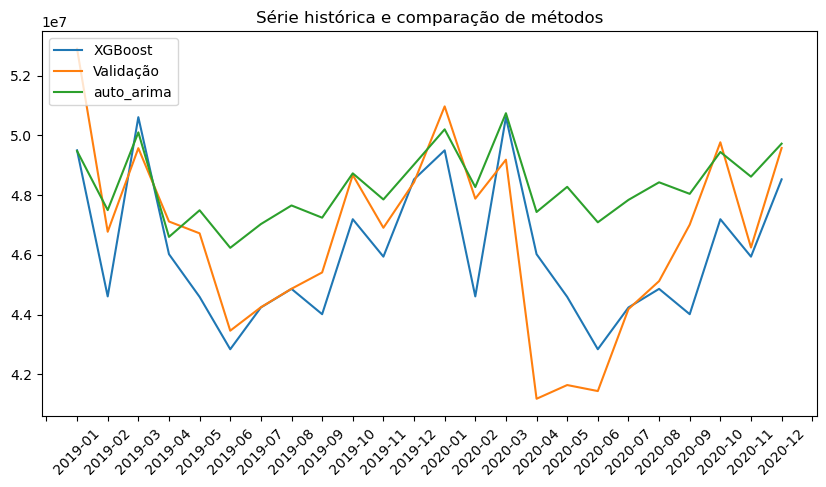

In [31]:
#--------------------------- Define modelo XGBoost --------------------#
modelBrasil = xgb.XGBRegressor()
modelBrasil.fit(brasil[['ano', 'mes']], brasil['val_geracao'])

#--------------------------- Predição -----------------------#
pred_brasil = pd.DataFrame(modelBrasil.predict(valid_brasil[['ano', 'mes']]))
#-----------------------Desenho e configuração do gráfico comparativo -----------------#
plt.figure(figsize = (10,5))
plt.plot(pred_brasil, label = 'XGBoost')
plt.plot(valid_brasil['val_geracao'], label = 'Validação')
plt.plot(forecastBrasil, label='auto_arima')
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1));
plt.xticks(rotation = 45);
plt.title('Série histórica e comparação de métodos')

Apesar de termos a percepção visual de que a curva do XGBoost se aproxima muito mais da curva de validação do que a do método auto_arima, é importante que possamos medir esse erro. Para isso usaremos o MAE, ou erro médio absoluto. Apesar das várias opções de medição de erro, essa foi escolhida por ser mais próxima do erro "médio" do nosso método escolhido. Para fins de praticidade, os erros serão computados apenas a respeito da geração nacional de energia, e não de cada subsistema:

In [29]:
erro_arima = mae(valid_brasil['val_geracao'], forecastBrasil)
print("MAE do método ARIMA: ", erro_arima)

erro_xgboost = mae(valid_brasil['val_geracao'], pred_brasil)
print("MAE do método XGBoost: ", erro_xgboost)

print("O erro do método XGBoost é", round(erro_xgboost/erro_arima * 100, 2), "% do erro do método ARIMA.")

MAE do método ARIMA:  2076178.0382133245
MAE do método XGBoost:  1541778.8168029161
O erro do método XGBoost é 74.26 % do erro do método ARIMA.


Assim, temos uma confirmação da nossa primeira inspeção visual. O método XGBoost, além de aproximadamente 60 vezes mais rápido que o método ARIMA, nesse problema específico, apresentou um erro 25% menor.